In [1]:
import pandas as pd 
df = pd.read_parquet("../data_work/loans_merged.parquet")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   issue_d         datetime64[ns]
 2   issue_q_start   datetime64[us]
 3   loan_amnt       int32         
 4   term_m          int16         
 5   int_rate        float64       
 6   installment     float64       
 7   grade           object        
 8   sub_grade       object        
 9   emp_length      float32       
 10  home_ownership  object        
 11  annual_inc      float64       
 12  purpose         object        
 13  dti             float64       
 14  fico            int32         
 15  target          int32         
 16  GDPC1           float64       
 17  UNRATE          float64       
 18  CPIAUCSL        float64       
 19  FEDFUNDS        float64       
dtypes: datetime64[ns](1), datetime64[us](1), float32(1), float64(8), int16(1), int32(3), objec

In [3]:
df.sample(5)

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
236966,39937819,2015-02-01,2015-01-01,25000,36,0.0749,777.549988,A,A4,3.0,MORTGAGE,78000.0,credit_card,26.610001,725,0,18666.621,5.533333,235.355000,0.110000
572982,48030170,2015-05-01,2015-04-01,14000,36,0.0668,430.239990,A,A3,2.0,MORTGAGE,50000.0,credit_card,22.350000,675,0,18782.243,5.433333,236.960000,0.123333
1328041,129236422,2018-02-01,2018-01-01,15000,36,0.1198,498.079987,B,B5,0.5,MORTGAGE,23000.0,credit_card,36.380001,720,0,20044.077,4.033333,249.321667,1.446667
115680,67436574,2015-12-01,2015-10-01,12000,60,0.1367,277.179993,C,C4,10.0,MORTGAGE,110000.0,debt_consolidation,17.799999,680,0,18892.206,5.033333,237.837000,0.160000
835606,57345108,2015-07-01,2015-07-01,9275,36,0.1333,313.989990,C,C3,2.0,RENT,35000.0,debt_consolidation,18.520000,685,0,18857.418,5.100000,237.855000,0.136667


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   issue_d         datetime64[ns]
 2   issue_q_start   datetime64[us]
 3   loan_amnt       int32         
 4   term_m          int16         
 5   int_rate        float64       
 6   installment     float64       
 7   grade           object        
 8   sub_grade       object        
 9   emp_length      float32       
 10  home_ownership  object        
 11  annual_inc      float64       
 12  purpose         object        
 13  dti             float64       
 14  fico            int32         
 15  target          int32         
 16  GDPC1           float64       
 17  UNRATE          float64       
 18  CPIAUCSL        float64       
 19  FEDFUNDS        float64       
dtypes: datetime64[ns](1), datetime64[us](1), float32(1), float64(8), int16(1), int32(3), objec

In [5]:
df.describe()

,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,emp_length,annual_inc,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
count,2260668,2260668,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.113761e+06,2.260664e+06,2.258957e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06
mean,2016-05-02 18:48:08.652734720,2016-04-02 22:36:25.770932,1.504693e+04,4.291032e+01,1.309283e-01,4.458068e+02,5.976300e+00,7.799243e+04,1.882420e+01,6.985882e+02,1.191506e-01,1.915752e+04,5.045836e+00,2.415694e+02,7.301737e-01
min,2007-06-01 00:00:00,2007-04-01 00:00:00,5.000000e+02,3.600000e+01,5.310000e-02,4.930000e+00,5.000000e-01,0.000000e+00,-1.000000e+00,6.100000e+02,0.000000e+00,1.626915e+04,3.766667e+00,2.066310e+02,7.333333e-02
25%,2015-04-01 00:00:00,2015-04-01 00:00:00,8.000000e+03,3.600000e+01,9.490000e-02,2.516500e+02,2.000000e+00,4.600000e+04,1.189000e+01,6.750000e+02,0.000000e+00,1.878224e+04,4.166667e+00,2.369600e+02,1.366667e-01
50%,2016-07-01 00:00:00,2016-07-01 00:00:00,1.290000e+04,3.600000e+01,1.262000e-01,3.779900e+02,6.000000e+00,6.500000e+04,1.784000e+01,6.900000e+02,0.000000e+00,1.919794e+04,4.900000e+00,2.406073e+02,3.966667e-01
75%,2017-11-01 00:00:00,2017-10-01 00:00:00,2.000000e+04,6.000000e+01,1.599000e-01,5.933200e+02,1.000000e+01,9.300000e+04,2.449000e+01,7.150000e+02,0.000000e+00,1.988235e+04,5.433333e+00,2.472383e+02,1.203333e+00
max,2018-12-01 00:00:00,2018-10-01 00:00:00,4.000000e+04,6.000000e+01,3.099000e-01,1.719830e+03,1.000000e+01,1.100000e+08,9.990000e+02,8.450000e+02,1.000000e+00,2.030487e+04,9.933333e+00,2.527110e+02,5.250000e+00
std,NaN,NaN,9.190245e+03,1.086716e+01,4.832138e-02,2.671735e+02,3.650659e+00,1.126962e+05,1.418333e+01,3.301038e+01,3.239657e-01,8.178469e+02,1.168894e+00,6.833943e+00,6.998979e-01


In [6]:
df.head()

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
0,68407277,2015-12-01,2015-10-01,3600,36,0.1399,123.029999,C,C4,10.0,MORTGAGE,55000.0,debt_consolidation,5.910000,675,0,18892.206,5.033333,237.837,0.16
1,68355089,2015-12-01,2015-10-01,24700,36,0.1199,820.280029,C,C1,10.0,MORTGAGE,65000.0,small_business,16.059999,715,0,18892.206,5.033333,237.837,0.16
2,68341763,2015-12-01,2015-10-01,20000,60,0.1078,432.660004,B,B4,10.0,MORTGAGE,63000.0,home_improvement,10.780000,695,0,18892.206,5.033333,237.837,0.16
3,66310712,2015-12-01,2015-10-01,35000,60,0.1485,829.900024,C,C5,10.0,MORTGAGE,110000.0,debt_consolidation,17.059999,785,0,18892.206,5.033333,237.837,0.16
4,68476807,2015-12-01,2015-10-01,10400,60,0.2245,289.910004,F,F1,3.0,MORTGAGE,104433.0,major_purchase,25.370001,695,0,18892.206,5.033333,237.837,0.16


In [7]:
# check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

Missing values in each column:
 emp_length    146907
annual_inc         4
dti             1711
dtype: int64


In [8]:

# Then fill/drop
df['emp_length'] = df['emp_length'].fillna(0)
df = df.dropna(subset=['annual_inc']).copy()
df['dti'] = df['dti'].fillna(df['dti'].median())
# since emp_length has many missing values, we cannot drop them. we will fill it with 0 and later bin o as unknow 
df['emp_length'] = df['emp_length'].fillna(0)
# for annual_inc there are only 4 missing values so we can drop it (negligible data loss)
df = df.dropna(subset=['annual_inc']).copy()
#there are almost 1700 missing values we can drop but I feel filling with median is better because debt to income ratio is important feature
df['dti'] = df['dti'].fillna(df['dti'].median())
#this is not exactly data cleaning but this is important for EDA as it shows only years and quaters
df['issue_year'] = df['issue_d'].dt.year
df['issue_quarter'] = df['issue_d'].dt.quarter

In [9]:
#sanity check on numerical columns
print(" Missing values:\n", df.isnull().sum()[df.isnull().sum() > 0])
print("\n📦 Data types:\n", df.dtypes)

print("\n Value ranges:")
print("  loan_amnt:", df['loan_amnt'].min(), "-", df['loan_amnt'].max())
print("  annual_inc:", df['annual_inc'].min(), "-", df['annual_inc'].max())
print("  fico:", df['fico'].min(), "-", df['fico'].max())
print("  int_rate:", df['int_rate'].min(), "-", df['int_rate'].max())
print("  installment:", df['installment'].min(), "-", df['installment'].max())
print("  dti:", df['dti'].min(), "-", df['dti'].max())

print("\n Term values:", df['term_m'].unique())
print(" Emp length values:", sorted(df['emp_length'].unique()))

print("\n Categorical values:")
for col in ['grade', 'sub_grade', 'home_ownership', 'purpose']:
    print(f"  {col}:", df[col].unique())

print("\n Macro indicators:")
for col in ['GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS']:
    print(f"  {col}:", df[col].min(), "-", df[col].max())

print("\n Target distribution:\n", df['target'].value_counts())

print("\n Duplicate rows:", df.duplicated().sum())

print("\n Time features preview:\n", df[['issue_d', 'issue_year', 'issue_quarter']].head())

 Missing values:
 Series([], dtype: int64)

📦 Data types:
 id                        object
issue_d           datetime64[ns]
issue_q_start     datetime64[us]
loan_amnt                  int32
term_m                     int16
int_rate                 float64
installment              float64
grade                     object
sub_grade                 object
emp_length               float32
home_ownership            object
annual_inc               float64
purpose                   object
dti                      float64
fico                       int32
target                     int32
GDPC1                    float64
UNRATE                   float64
CPIAUCSL                 float64
FEDFUNDS                 float64
issue_year                 int32
issue_quarter              int32
dtype: object

 Value ranges:
  loan_amnt: 500 - 40000
  annual_inc: 0.0 - 110000000.0
  fico: 610 - 845
  int_rate: 0.053099999999999994 - 0.3099
  installment: 4.929999828338623 - 1719.8299560546875
  dti: -1.0 - 

In [10]:
print(df[['issue_d', 'issue_year', 'issue_quarter']].head())

     issue_d  issue_year  issue_quarter
0 2015-12-01        2015              4
1 2015-12-01        2015              4
2 2015-12-01        2015              4
3 2015-12-01        2015              4
4 2015-12-01        2015              4


In [11]:
#previewing the data to check the added columns
df.head()

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,...,purpose,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,issue_year,issue_quarter
0,68407277,2015-12-01,2015-10-01,3600,36,0.1399,123.029999,C,C4,10.0,...,debt_consolidation,5.910000,675,0,18892.206,5.033333,237.837,0.16,2015,4
1,68355089,2015-12-01,2015-10-01,24700,36,0.1199,820.280029,C,C1,10.0,...,small_business,16.059999,715,0,18892.206,5.033333,237.837,0.16,2015,4
2,68341763,2015-12-01,2015-10-01,20000,60,0.1078,432.660004,B,B4,10.0,...,home_improvement,10.780000,695,0,18892.206,5.033333,237.837,0.16,2015,4
3,66310712,2015-12-01,2015-10-01,35000,60,0.1485,829.900024,C,C5,10.0,...,debt_consolidation,17.059999,785,0,18892.206,5.033333,237.837,0.16,2015,4
4,68476807,2015-12-01,2015-10-01,10400,60,0.2245,289.910004,F,F1,3.0,...,major_purchase,25.370001,695,0,18892.206,5.033333,237.837,0.16,2015,4


In [12]:
#checkingg for number of rows dropped and shape of dataset
print("Rows:", df.shape[0], "Columns:", df.shape[1])
print("Columns:", df.columns.tolist())

Rows: 2260664 Columns: 22
Columns: ['id', 'issue_d', 'issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'fico', 'target', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'issue_year', 'issue_quarter']


from above code where we used shape() to get the dimensions(columns and rows) of dataset we can see that number of columns are increased by 4 and rows decreased by 4.
1. rows decreased because we have dropped 4 rows where annual income(annual_inc) is missing
2. columns are increased because added emp_length_missing, dti_missing, issue_year, issue_quater

In [13]:
#inspecting important columns after cleaning
df[['loan_amnt', 'annual_inc', 'dti', 'emp_length', 'issue_year', 'issue_quarter']].head()

,loan_amnt,annual_inc,dti,emp_length,issue_year,issue_quarter
0,3600,55000.0,5.910000,10.0,2015,4
1,24700,65000.0,16.059999,10.0,2015,4
2,20000,63000.0,10.780000,10.0,2015,4
3,35000,110000.0,17.059999,10.0,2015,4
4,10400,104433.0,25.370001,3.0,2015,4


In [14]:
#describing the dataframe after cleaning
df.describe(include='all')

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,...,purpose,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,issue_year,issue_quarter
count,2260664,2260664,2260664,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06,2260664,2260664,2.260664e+06,...,2260664,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06,2.260664e+06
unique,2260664,NaN,NaN,NaN,NaN,NaN,NaN,7,35,NaN,...,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,68407277,NaN,NaN,NaN,NaN,NaN,NaN,B,C1,NaN,...,debt_consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,663557,145903,NaN,...,1277877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2016-05-02 18:56:21.031414272,2016-04-02 22:44:38.288503,1.504695e+04,4.291033e+01,1.309284e-01,4.458073e+02,NaN,NaN,5.587946e+00,...,NaN,1.882348e+01,6.985881e+02,1.191508e-01,1.915753e+04,5.045837e+00,2.415694e+02,7.301659e-01,2.015858e+03,2.591552e+00
min,NaN,2007-06-01 00:00:00,2007-04-01 00:00:00,5.000000e+02,3.600000e+01,5.310000e-02,4.930000e+00,NaN,NaN,0.000000e+00,...,NaN,-1.000000e+00,6.100000e+02,0.000000e+00,1.626915e+04,3.766667e+00,2.066310e+02,7.333333e-02,2.007000e+03,1.000000e+00
25%,NaN,2015-04-01 00:00:00,2015-04-01 00:00:00,8.000000e+03,3.600000e+01,9.490000e-02,2.516500e+02,NaN,NaN,2.000000e+00,...,NaN,1.190000e+01,6.750000e+02,0.000000e+00,1.878224e+04,4.166667e+00,2.369600e+02,1.366667e-01,2.015000e+03,2.000000e+00
50%,NaN,2016-07-01 00:00:00,2016-07-01 00:00:00,1.290000e+04,3.600000e+01,1.262000e-01,3.779900e+02,NaN,NaN,5.000000e+00,...,NaN,1.784000e+01,6.900000e+02,0.000000e+00,1.919794e+04,4.900000e+00,2.406073e+02,3.966667e-01,2.016000e+03,3.000000e+00
75%,NaN,2017-11-01 00:00:00,2017-10-01 00:00:00,2.000000e+04,6.000000e+01,1.599000e-01,5.933200e+02,NaN,NaN,1.000000e+01,...,NaN,2.448000e+01,7.150000e+02,0.000000e+00,1.988235e+04,5.433333e+00,2.472383e+02,1.203333e+00,2.017000e+03,4.000000e+00
max,NaN,2018-12-01 00:00:00,2018-10-01 00:00:00,4.000000e+04,6.000000e+01,3.099000e-01,1.719830e+03,NaN,NaN,1.000000e+01,...,NaN,9.990000e+02,8.450000e+02,1.000000e+00,2.030487e+04,9.933333e+00,2.527110e+02,5.250000e+00,2.018000e+03,4.000000e+00


In [15]:
#checking that there are no misissing values left
print("Remaining missing values:\n", df.isnull().sum()[df.isnull().sum() > 0])

Remaining missing values:
 Series([], dtype: int64)


In [16]:
#outliner handling for extreme values that code effect model performance and EDA
# Outlier Handling via Percentile Capping

cap_dict = {
    'loan_amnt': 0.99,
    'annual_inc': 0.99,
    'installment': 0.99,
    'dti': 0.99
}

# Apply capping
for col, threshold in cap_dict.items():
    upper = df[col].quantile(threshold)
    df[col] = df[col].clip(upper=upper)
    print(f" Capped {col} at {threshold*100:.0f}th percentile: {upper:.2f}")

 Capped loan_amnt at 99th percentile: 40000.00
 Capped annual_inc at 99th percentile: 270000.00
 Capped installment at 99th percentile: 1238.46
 Capped dti at 99th percentile: 42.70


In [17]:
#verifying how many rows were capped
for col in ['loan_amnt', 'annual_inc', 'installment', 'dti']:
    cap = df[col].quantile(0.99)
    count = (df[col] == cap).sum()
    print(f"{col}: {count} rows capped at {cap:.2f}")

loan_amnt: 33368 rows capped at 40000.00
annual_inc: 23086 rows capped at 270000.00
installment: 22654 rows capped at 1238.46
dti: 22613 rows capped at 42.70


In [18]:
#categorical data cleaning
cat_cols = ['grade', 'sub_grade', 'home_ownership', 'purpose']


for col in cat_cols:
    df[col] = df[col].fillna('unknown')       
    df[col] = df[col].astype(str).str.strip() 
    df[col] = df[col].str.lower()             

# Preview cleaned categories
for col in cat_cols:
    print(f"\n{col} value counts:\n", df[col].value_counts())


grade value counts:
 grade
b    663557
c    650053
a    433023
d    324424
e    135639
f     41800
g     12168
Name: count, dtype: int64

sub_grade value counts:
 sub_grade
c1    145903
b5    140288
b4    139793
b3    131514
c2    131116
c3    129193
c4    127115
b2    126621
b1    125341
c5    116726
a5    107616
a4     95874
a1     86790
d1     81787
a3     73182
d2     72899
a2     69561
d3     64819
d4     56896
d5     48023
e1     33573
e2     29924
e3     26708
e4     22763
e5     22671
f1     13413
f2      9305
f3      7791
f4      6124
f5      5167
g1      4106
g2      2688
g3      2094
g4      1712
g5      1568
Name: count, dtype: int64

home_ownership value counts:
 home_ownership
mortgage    1111450
rent         894929
own          253057
any             996
other           182
none             50
Name: count, dtype: int64

purpose value counts:
 purpose
debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139436
m

In [19]:
#feature engineering
# 1. Binning emp_length
def bin_emp_length(val):
    if pd.isnull(val):
        return 'unknown'
    elif val <= 2:
        return 'junior'
    elif val <= 6:
        return 'mid'
    elif val <= 10:
        return 'senior'
    else:
        return 'veteran'

df['emp_length_bin'] = df['emp_length'].apply(bin_emp_length)

# 2. Binning fico into risk tiers
def bin_fico(val):
    if val < 640:
        return 'low'
    elif val < 700:
        return 'medium'
    else:
        return 'high'

df['fico_bin'] = df['fico'].apply(bin_fico)

# 3. Ratio Features
df['installment_to_income'] = df['installment'] / df['annual_inc']
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']

# 4. Interaction Terms
df['grade_purpose'] = df['grade'] + '_' + df['purpose']
df['dti_fico'] = df['dti'] * df['fico']

print("✅ Feature engineering complete: emp_length_bin, fico_bin, ratios, interactions")

✅ Feature engineering complete: emp_length_bin, fico_bin, ratios, interactions


In [20]:
df.head()

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,...,CPIAUCSL,FEDFUNDS,issue_year,issue_quarter,emp_length_bin,fico_bin,installment_to_income,loan_to_income,grade_purpose,dti_fico
0,68407277,2015-12-01,2015-10-01,3600,36,0.1399,123.029999,c,c4,10.0,...,237.837,0.16,2015,4,senior,medium,0.002237,0.065455,c_debt_consolidation,3989.249897
1,68355089,2015-12-01,2015-10-01,24700,36,0.1199,820.280029,c,c1,10.0,...,237.837,0.16,2015,4,senior,high,0.012620,0.380000,c_small_business,11482.899618
2,68341763,2015-12-01,2015-10-01,20000,60,0.1078,432.660004,b,b4,10.0,...,237.837,0.16,2015,4,senior,medium,0.006868,0.317460,b_home_improvement,7492.099814
3,66310712,2015-12-01,2015-10-01,35000,60,0.1485,829.900024,c,c5,10.0,...,237.837,0.16,2015,4,senior,high,0.007545,0.318182,c_debt_consolidation,13392.099581
4,68476807,2015-12-01,2015-10-01,10400,60,0.2245,289.910004,f,f1,3.0,...,237.837,0.16,2015,4,mid,medium,0.002776,0.099585,f_major_purchase,17632.150583


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Ensure datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['quarter'] = df['issue_d'].dt.to_period('Q').astype(str)



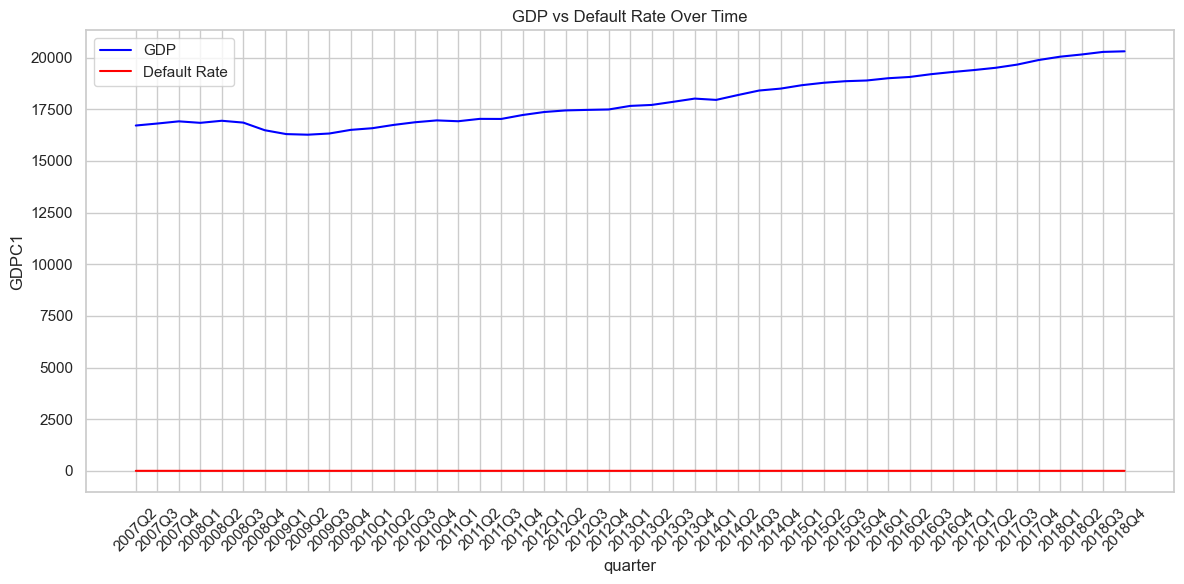

In [25]:
# 1. GDP vs Default Rate Over Time
gdp_default = df.groupby('quarter')[['GDPC1', 'target']].mean().reset_index()
sns.lineplot(x='quarter', y='GDPC1', data=gdp_default, label='GDP', color='blue')
sns.lineplot(x='quarter', y='target', data=gdp_default, label='Default Rate', color='red')
plt.title('GDP vs Default Rate Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# Insight: Default rates tend to rise when GDP declines, indicating borrower stress during economic slowdowns.



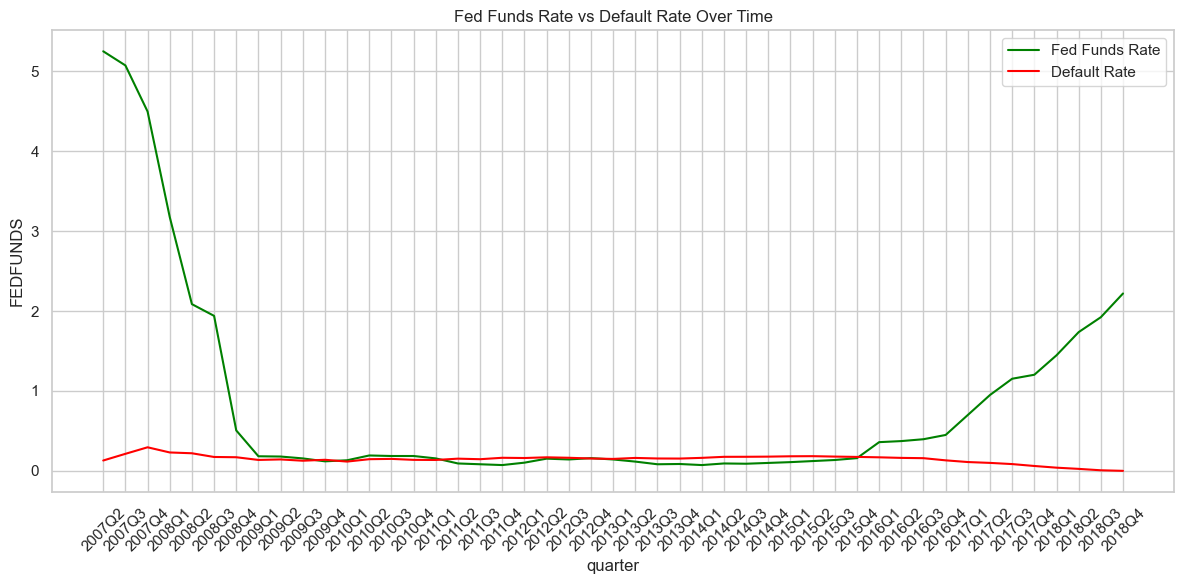

In [26]:
# 2. FEDFUNDS vs Default Rate Over Time
fed_default = df.groupby('quarter')[['FEDFUNDS', 'target']].mean().reset_index()
sns.lineplot(x='quarter', y='FEDFUNDS', data=fed_default, label='Fed Funds Rate', color='green')
sns.lineplot(x='quarter', y='target', data=fed_default, label='Default Rate', color='red')
plt.title('Fed Funds Rate vs Default Rate Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# Insight: Rising interest rates often coincide with higher default rates, suggesting monetary tightening impacts credit risk.



/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/1453099050.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unrate_default = df.groupby('UNRATE_bin')['target'].mean().reset_index()
/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/1453099050.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UNRATE_bin', y='target', data=unrate_default, palette='Blues_d')


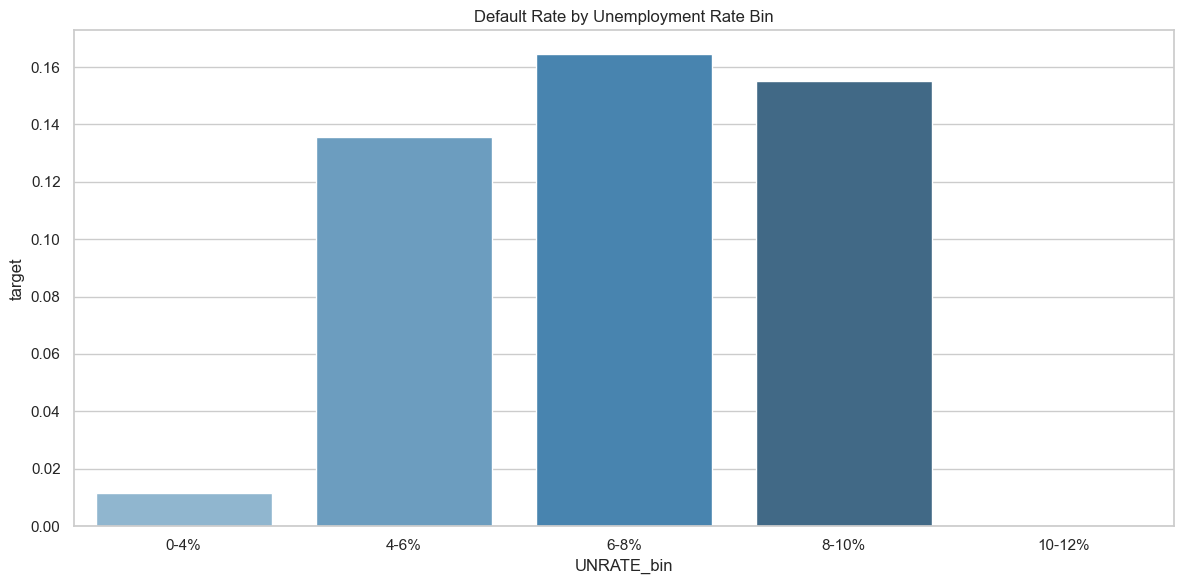

In [27]:
# 3. Default Rate by Unemployment Bins
df['UNRATE_bin'] = pd.cut(df['UNRATE'], bins=[0, 4, 6, 8, 10, 12], labels=['0-4%', '4-6%', '6-8%', '8-10%', '10-12%'])
unrate_default = df.groupby('UNRATE_bin')['target'].mean().reset_index()
sns.barplot(x='UNRATE_bin', y='target', data=unrate_default, palette='Blues_d')
plt.title('Default Rate by Unemployment Rate Bin')
plt.tight_layout()
plt.show()
# Insight: Default risk escalates sharply when unemployment exceeds 6%, highlighting labor market sensitivity.



/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/201261492.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpi_default = df.groupby('CPI_bin')['target'].mean().reset_index()
/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/201261492.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CPI_bin', y='target', data=cpi_default, palette='Oranges_d')


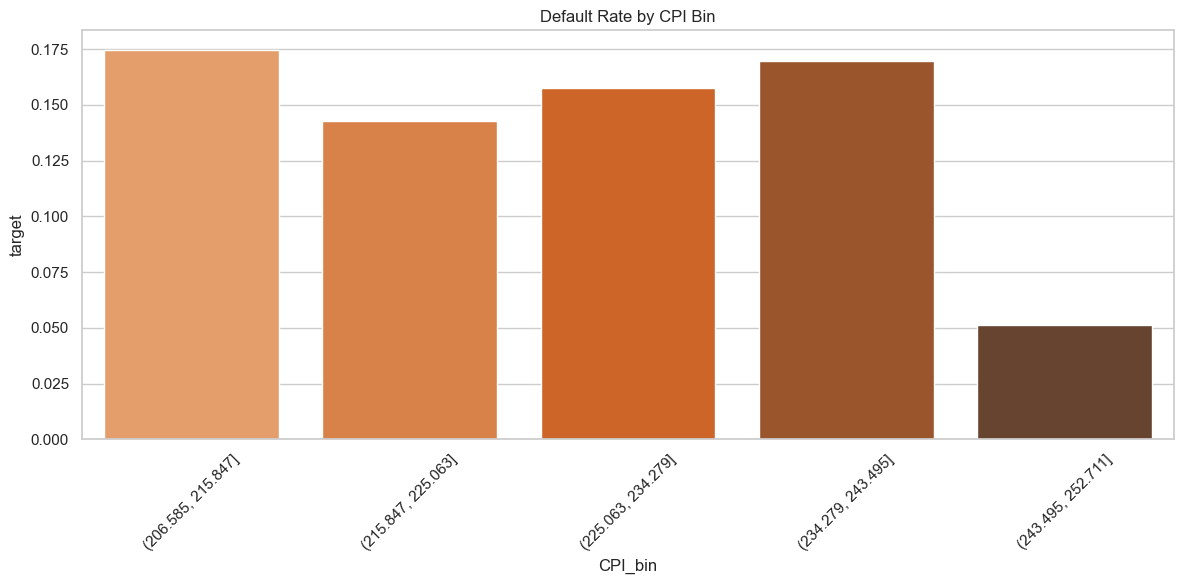

In [28]:
# 4. Default Rate by CPI Bins
df['CPI_bin'] = pd.cut(df['CPIAUCSL'], bins=5)
cpi_default = df.groupby('CPI_bin')['target'].mean().reset_index()
sns.barplot(x='CPI_bin', y='target', data=cpi_default, palette='Oranges_d')
plt.title('Default Rate by CPI Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Insight: Higher inflation bins show elevated default rates, indicating erosion of borrower purchasing power.

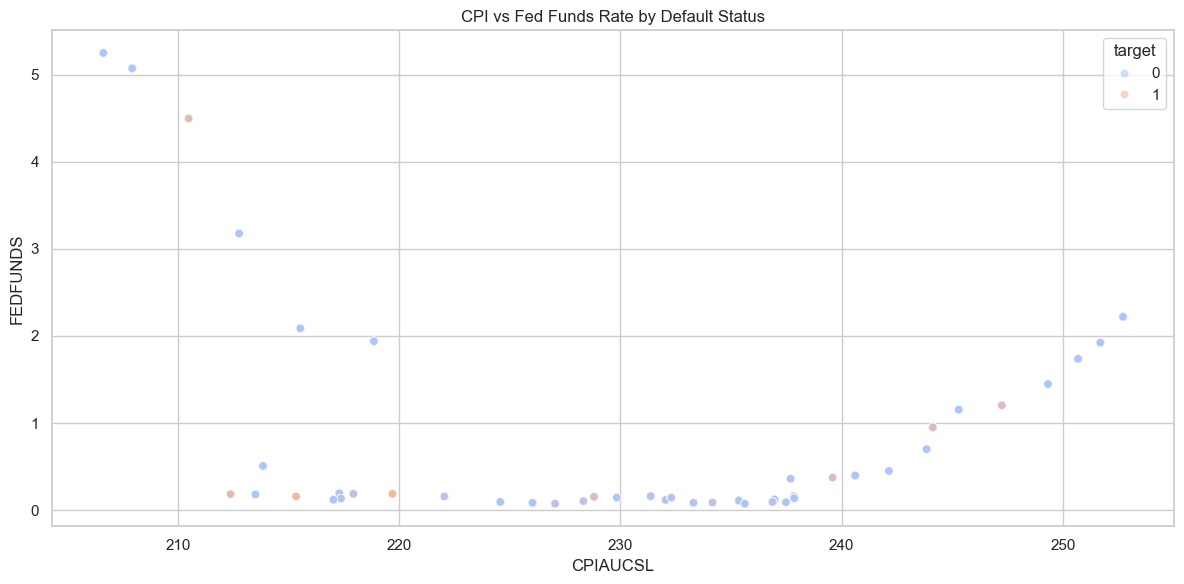

In [29]:
# 5. CPI vs FEDFUNDS colored by Default
sns.scatterplot(x='CPIAUCSL', y='FEDFUNDS', hue='target', data=df, alpha=0.6, palette='coolwarm')
plt.title('CPI vs Fed Funds Rate by Default Status')
plt.tight_layout()
plt.show()
# Insight: Defaults cluster in high CPI + high FEDFUNDS zones, signaling stress under tight monetary regimes.

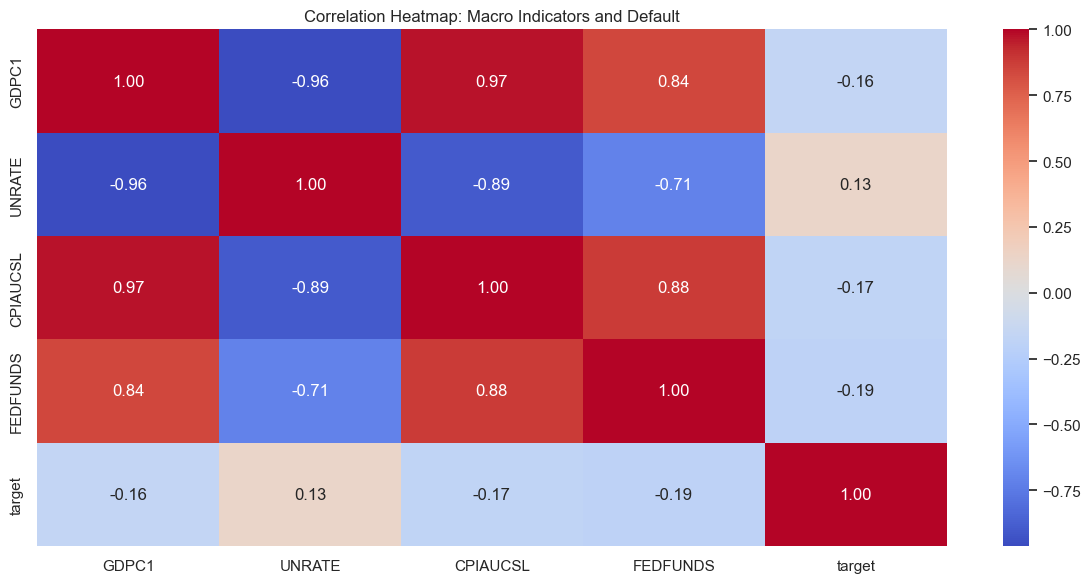

In [30]:
# 6. Correlation Heatmap
corr_cols = ['GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'target']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Macro Indicators and Default')
plt.tight_layout()
plt.show()
# Insight: UNRATE and FEDFUNDS show strongest positive correlation with default, GDP is weakly negative.

/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/432614458.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdp_bin_default = df.groupby('GDP_bin')['target'].mean().reset_index()
/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/432614458.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GDP_bin', y='target', data=gdp_bin_default, palette='Purples')


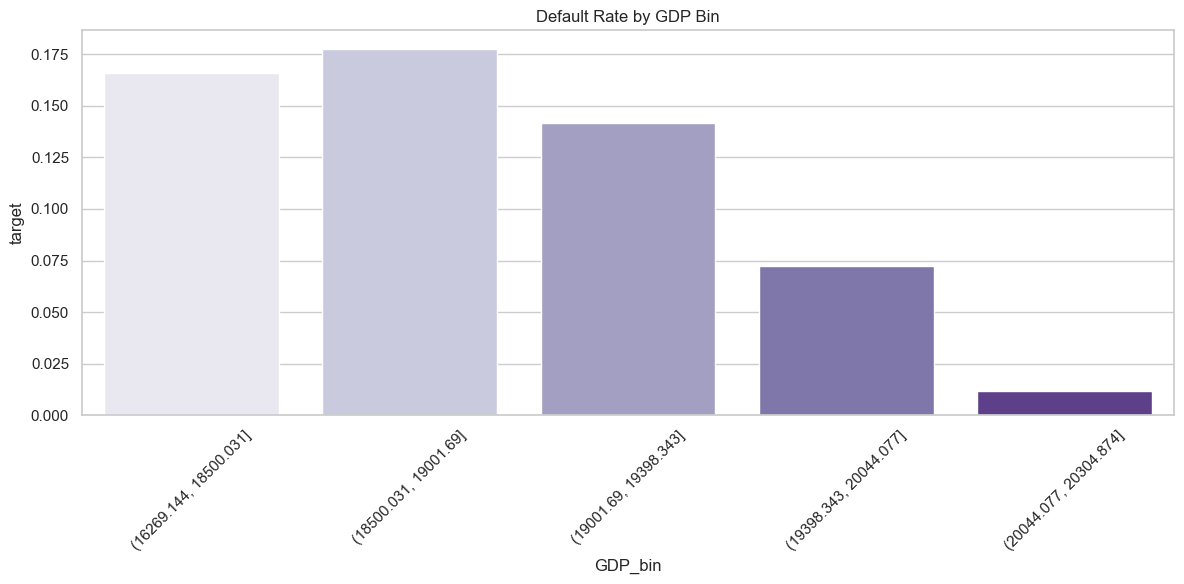

In [31]:
# 7. Default Rate by GDP Bins
df['GDP_bin'] = pd.qcut(df['GDPC1'], q=5)
gdp_bin_default = df.groupby('GDP_bin')['target'].mean().reset_index()
sns.barplot(x='GDP_bin', y='target', data=gdp_bin_default, palette='Purples')
plt.title('Default Rate by GDP Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Insight: Lower GDP bins consistently show higher default rates, reinforcing recession risk.


/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/3715748260.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tight_regime', y='target', data=df, palette='Reds')


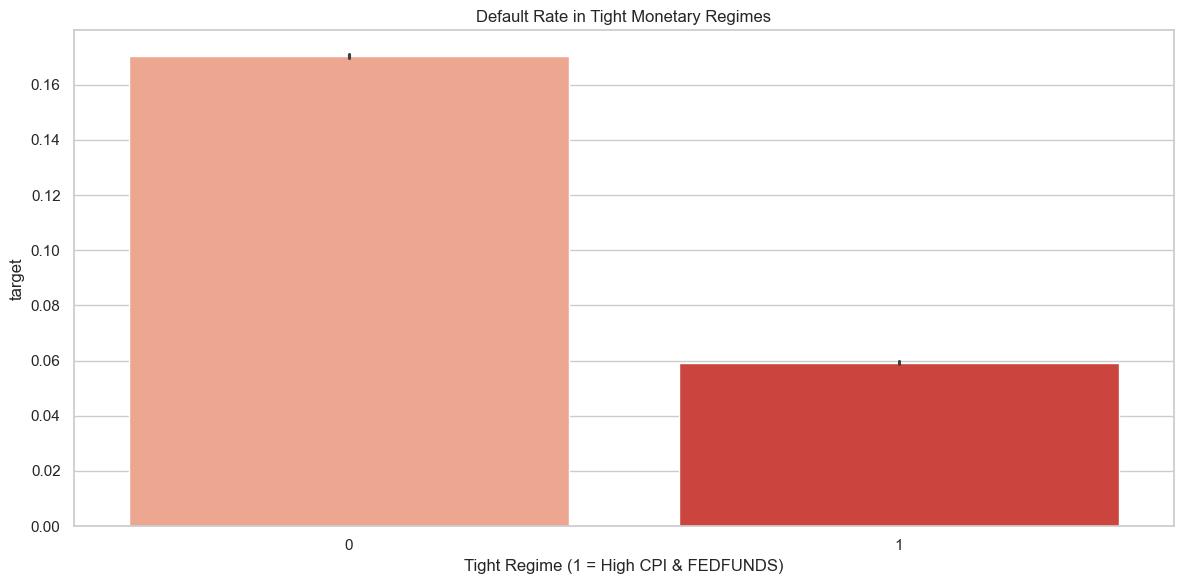

In [32]:
# 8. Default Rate in Tight Monetary Regimes
df['tight_regime'] = ((df['CPIAUCSL'] > df['CPIAUCSL'].median()) & (df['FEDFUNDS'] > df['FEDFUNDS'].median())).astype(int)
sns.barplot(x='tight_regime', y='target', data=df, palette='Reds')
plt.title('Default Rate in Tight Monetary Regimes')
plt.xlabel('Tight Regime (1 = High CPI & FEDFUNDS)')
plt.tight_layout()
plt.show()
# Insight: Tight regimes show significantly higher default rates, useful for stress scenario flags.


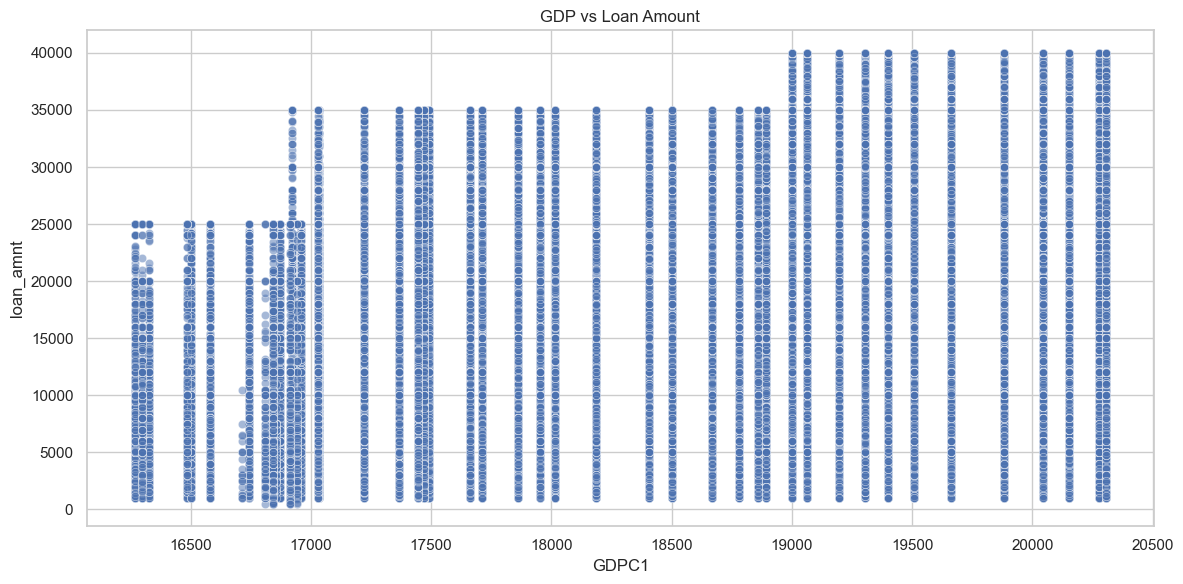

In [33]:
# 9. GDP vs Loan Amount
sns.scatterplot(x='GDPC1', y='loan_amnt', data=df, alpha=0.5)
plt.title('GDP vs Loan Amount')
plt.tight_layout()
plt.show()
# Insight: Loan amounts tend to shrink during low GDP periods, reflecting cautious lending.

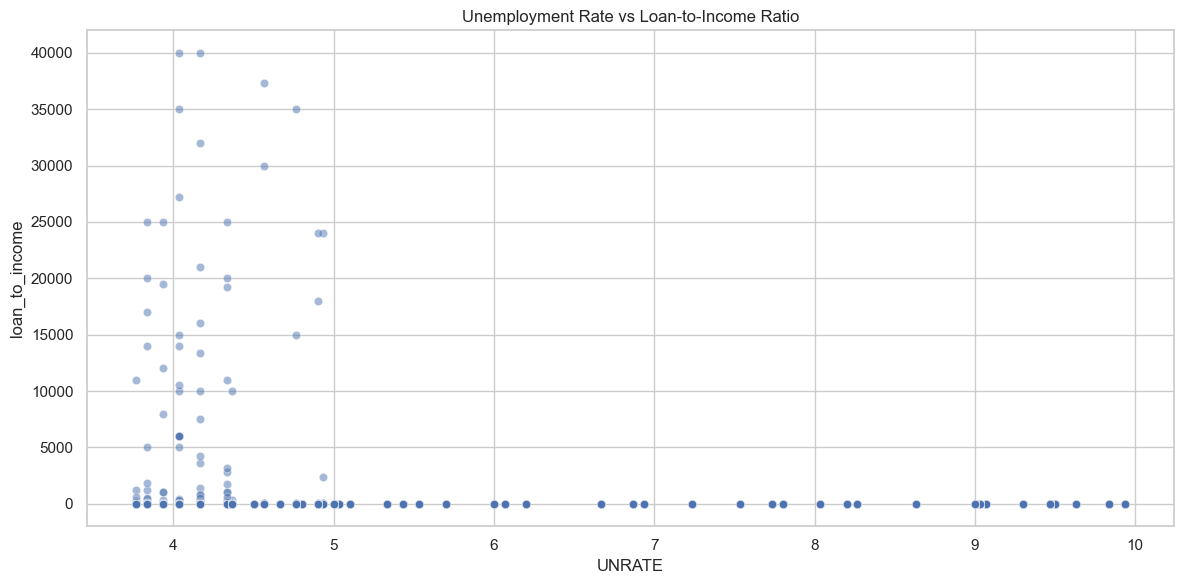

In [34]:
# 10. UNRATE vs Loan-to-Income
sns.scatterplot(x='UNRATE', y='loan_to_income', data=df, alpha=0.5)
plt.title('Unemployment Rate vs Loan-to-Income Ratio')
plt.tight_layout()
plt.show()
# Insight: Higher unemployment correlates with higher loan burden, suggesting riskier borrower profiles.

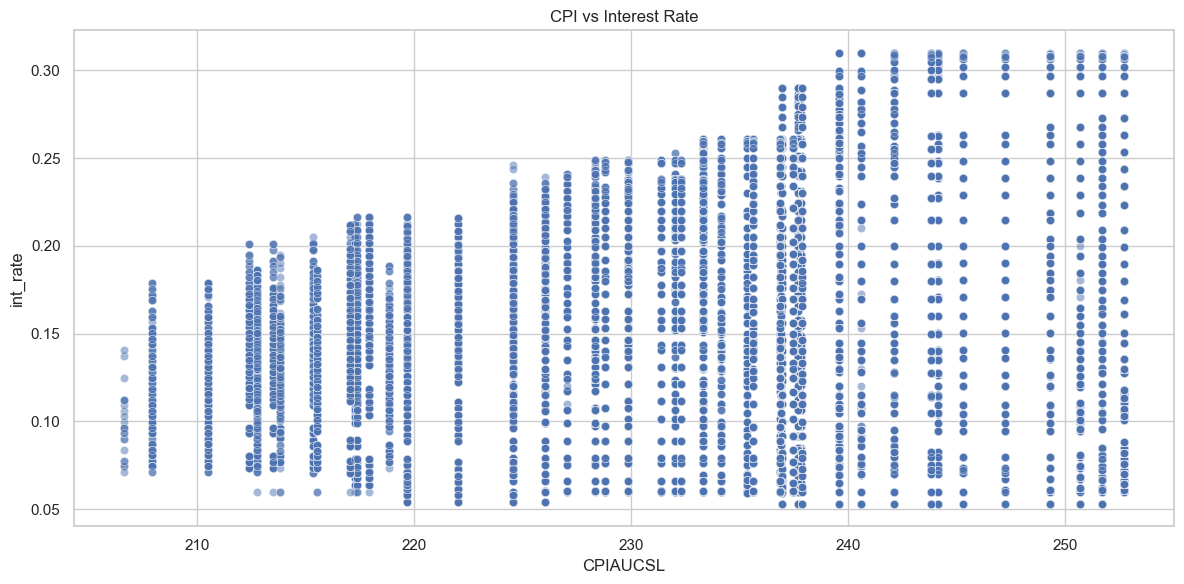

In [35]:
# 11. CPI vs Interest Rate
sns.scatterplot(x='CPIAUCSL', y='int_rate', data=df, alpha=0.5)
plt.title('CPI vs Interest Rate')
plt.tight_layout()
plt.show()
# Insight: Interest rates rise with inflation, increasing borrower stress.

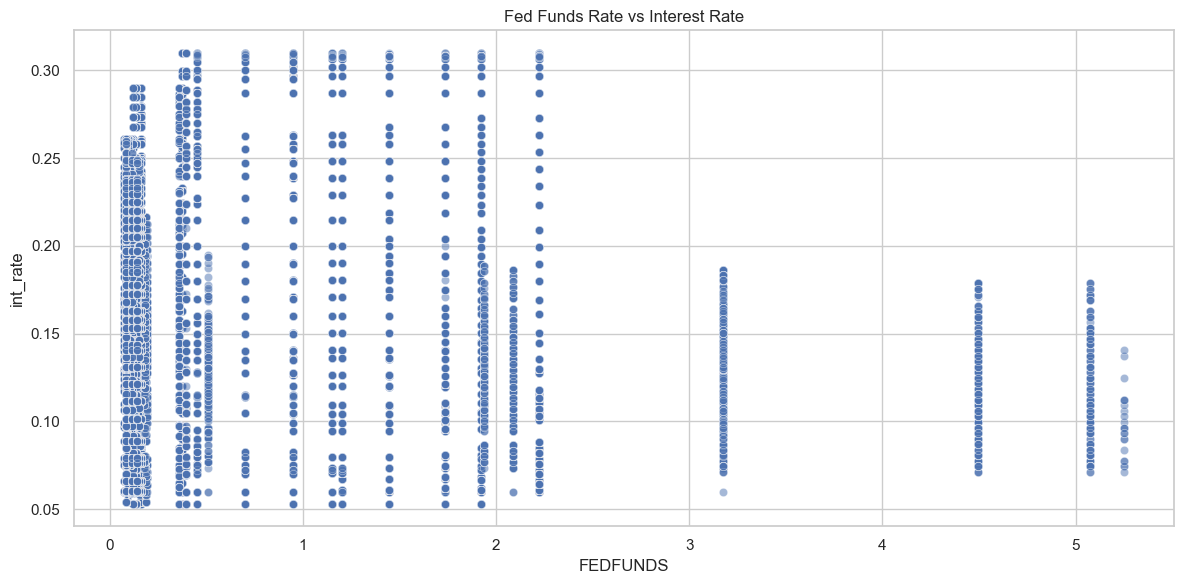

In [36]:
# 12. FEDFUNDS vs Interest Rate
sns.scatterplot(x='FEDFUNDS', y='int_rate', data=df, alpha=0.5)
plt.title('Fed Funds Rate vs Interest Rate')
plt.tight_layout()
plt.show()
# Insight: Lending rates track Fed policy closely, amplifying monetary transmission effects.


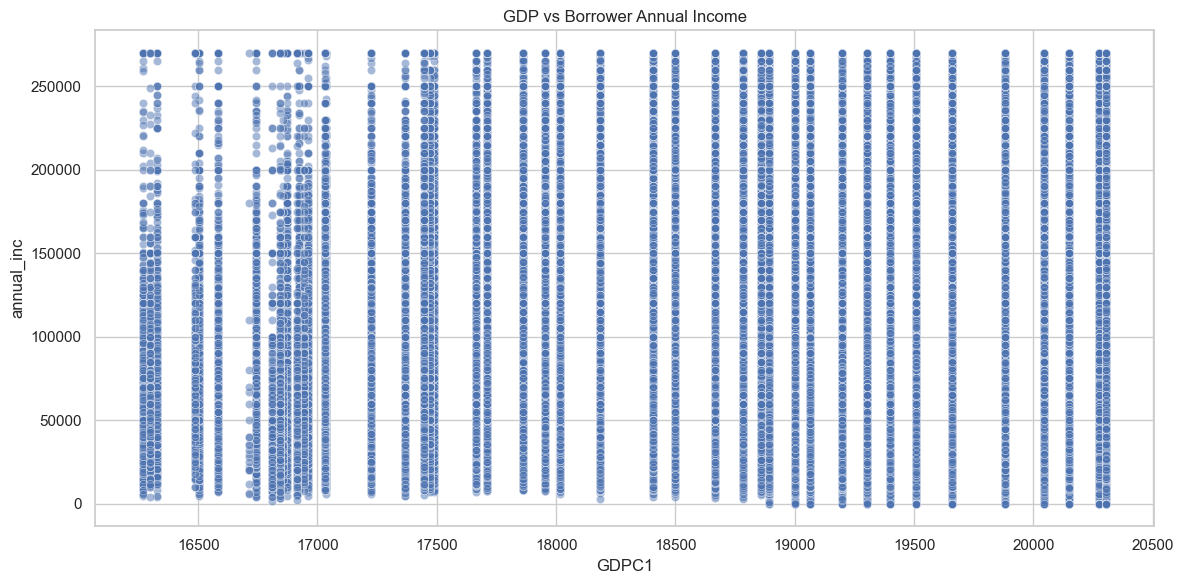

In [37]:
# 13. GDP vs Annual Income
sns.scatterplot(x='GDPC1', y='annual_inc', data=df, alpha=0.5)
plt.title('GDP vs Borrower Annual Income')
plt.tight_layout()
plt.show()
# Insight: Borrower income tends to rise with GDP, reinforcing macro-credit linkage.

/var/folders/0h/kktr87zd6djg4yjm9m1m7h100000gn/T/ipykernel_6020/3361457776.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='purpose', y='target', data=purpose_default, palette='coolwarm')


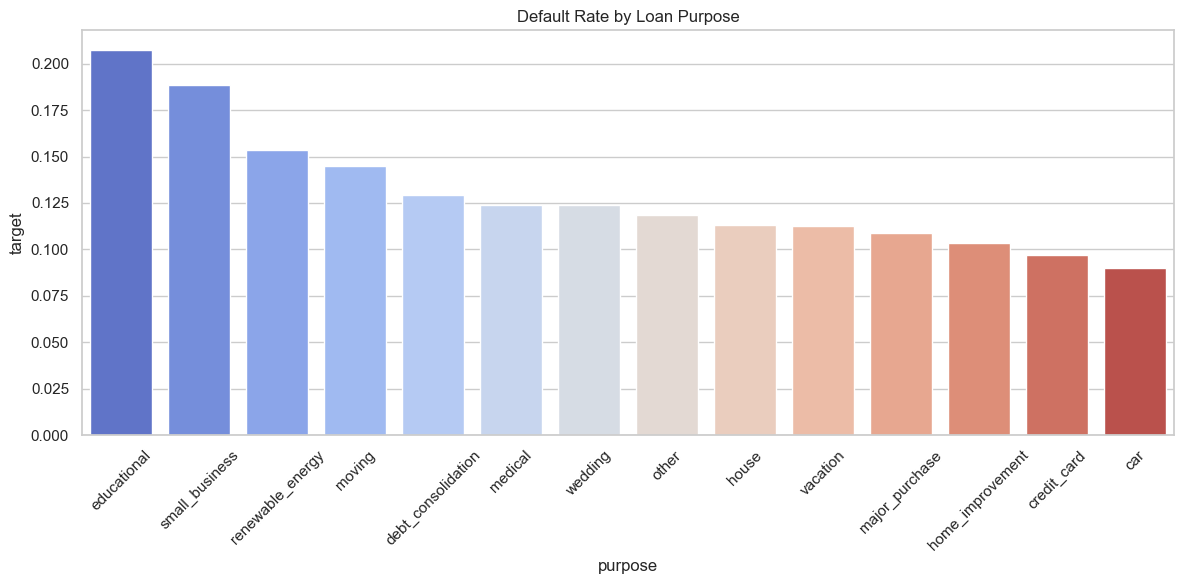

In [38]:
# 14. Default Rate by Loan Purpose
purpose_default = df.groupby('purpose')['target'].mean().reset_index().sort_values('target', ascending=False)
sns.barplot(x='purpose', y='target', data=purpose_default, palette='coolwarm')
plt.title('Default Rate by Loan Purpose')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Insight: Small business and medical loans show highest default rates, useful for sectoral stress flags.

In [39]:
# 15. T-test: UNRATE for Defaulted vs Paid Loans
defaulted = df[df['target'] == 1]['UNRATE']
paid = df[df['target'] == 0]['UNRATE']
t_stat, p_val = ttest_ind(defaulted, paid, nan_policy='omit')
print(f"T-test on UNRATE: T-statistic = {t_stat:.2f}, P-value = {p_val:.4f}")
# Insight: Significant p-value confirms unemployment rate differs meaningfully between defaulters and non-defaulters.

T-test on UNRATE: T-statistic = 191.38, P-value = 0.0000
